In this article i want to examine whether Dollar Cost Averaging (DCA) is something reasonable to do for bitcoin investments. In general, the assumption is that your asset-price goes up __eventually__ but might have significant volatility on its way. With DCA you want to somehow make it easier for you to buy as you can streamline the ups and downs better.

The code and the whole approach is mostly shamelessly copied from http://www.samansari.info/2016/01/lump-sum-vs-dollar-cost-averaging-dca.html, so kudos to Sameer! Also the results are very similiar although there are significant changes in the approach.

So let's use even the same wording as in Sameer's article:

Both lump-sum investing and DCA have their appropriate time and place. The research shows that lump-sum investing pays off about 66% of the time, which is a long way from all the time. It certainly makes sense to look carefully at the current market conditions. If you hit that bad 33% in lumpy style, you can lose a lot of money.


# Difference in the approach
Comparing to Sameer's approach, we have some significant differences used here:
* The Standard & Poor's 500 is measured since year 2000 and the DCA is based on monthly investments. Because Bitcoin-exchanges are charging their fees based on percentages, rather than fixed amounts and we only have 7 years of price-data, we'll use DCA based on daily purchases. On top of that we'll also compare that to monthly purchases, later on.
* The timeframe is not different. We're both calculating with one year. CHanging that has a huge impact on how the number are turning out.
* The unit of account is measured in btc, not in dollars. The goal of the investment is to make as much btc as possible. Prices at persiods after the investment are mostly irrelevant. As a side-effect, that will make the calculations a bit easier.
* The difference of both values was in my opinion not very meaningful. Eventually, we don't only want to know how often one is superior to the other, you also want to know by how much on average. That is best expressed by perecentages and that's why we're using here a quotient rather then a difference

# Price Data
the Data will come from http://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz which we'll here load from directly from Harddrive.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
pd.set_option('display.width', 200) # Displaying more columns in one row
btc = pd.read_csv("./bitstampUSD.csv.gz",compression='gzip',header=None)
btc.columns = ['unixtimestamp', 'price','unknown']
btc["timestamp"]= pd.to_datetime(btc.unixtimestamp,unit='s')
btc.index = btc["timestamp"]
print("So now we have {} datapoints and the first price is from {}".format(btc.shape[0],btc.timestamp[0]))

So now we have 28200822 datapoints and the first price is from 2011-09-13 13:53:36


So these are price-data BELOW the minute-resolution. So let's resample the data to daily prices and also fill gaps.

In [2]:
daily_prices = pd.DataFrame()
daily_prices['price'] = btc.price.resample('D').mean()
btc = daily_prices
# the first year is not very reliable, we'll skip it.
#btc = btc[btc.index > '2012-1-1']
btc.fillna(method='ffill',inplace=True) # replace Null-values with forwardfill
print("So now we have {} datapoints".format(btc.shape[0]))

So now we have 2603 datapoints


So here is the plot of the pricegraph:

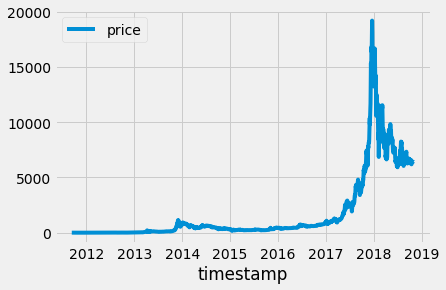

In [10]:
btc.plot()

# What do we exactly mean by DCA/Lumpsum?

No we'll create two functions which will both calculate the yield of an investment:
* doDCA will assume that someone will invest daily for number_of_days and starting on start_date.
* doLump will take the same arguments, but assume that you invest all of that at the very beginning.

In [4]:
from datetime import timedelta
def doDCA(start_date, number_of_days,mode="d"):
    # Get 2 years of daily investment-dates starting from start date
    if mode=="d":
        investment_dates_all = pd.date_range(start_date,periods=number_of_days,freq='1D')
    else :
        investment_dates_all = pd.date_range(start_date,periods=number_of_days/30,freq='30D')
    # Remove those dates beyond our known data range
    investment_dates = investment_dates_all[investment_dates_all < btc.index[-1]]
    investment_dates = investment_dates[investment_dates_all > btc.index[0]]

    # Get closest business dates with available data
    closest_investment_dates = btc.index.searchsorted(investment_dates)

    # How much to invest on each date
    if mode=="d":
        portion = 6 # 6 dollar per day
    else :
        portion = 6 * 30

    # Get the total of all stocks purchased for each of those dates (on the Close)
    dca_invested_btc = sum(portion / btc['price'][closest_investment_dates])

    try:
        #start_date_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
        #if ( (start_date_date + timedelta(days=number_of_days)) >= btc.index[-1] ):
        #    return 0
        total_value = dca_invested_btc
        # Potentially we could calculate the total-value based on the end of the investment period
        #total_value = btc.loc[str((start_date + timedelta(days=number_of_days)).date())].price*dca_invested_btc
        return total_value 
    except:
        return 0

def doLump(start_date,number_of_days):
    try:
        lump_invested_btc = 6*number_of_days / btc.loc[str((start_date).date())].price
        total_value = btc.price[-1] * lump_invested_btc
        # Potentially we could calculate the total-value based on the end of the investment period
        #total_value = btc.loc[str((start_date + timedelta(days=number_of_days)).date())].price*lump_invested_btc
        return lump_invested_btc
    except:
        return None

# Calculating over one year for each day we can

Now we're executing the function for every day of our bitcoin price-chart starting from the beginning of 2011. 

We will  assume a daily investment of \$ 6 and 1 year of investing.

This would result in a lump-sum-investment of 6\*365=\$2190

From a practical point of view, the following calculations should answer the question whether an investor should invest \$ 2190 immediately or $6 per day over a year.

In [5]:
# Generate DCA series for every possible date
number_of_days=365
start_date='2011-1-1'
date_range=btc[btc.index > start_date]

dca = pd.Series(date_range.index.map(lambda x: doDCA(x,number_of_days)), index=date_range.index, name='Dollar Cost Averaging (DCA)')
# We also calculate what would happen to buy monthly instead of daily
dca_monthly = pd.Series(date_range.index.map(lambda x: doDCA(x,number_of_days,"m")), index=date_range.index, name='Dollar Cost Averaging (DCA) Monthly')
lump = pd.Series(date_range.index.map(lambda x: doLump(x, number_of_days)), index=date_range.index, name='Lump Sum Investment')
quotient = (dca[0:2500] / lump[0:2500]) # We have to cut off the last year otherwise we get stupid data
quotient.name = 'Quotient (DCA / Lump Sum)'

In [6]:


print("Lump sum returns more than DCA %.1f%% of all the days" % (100*sum(quotient<1)/len(quotient)))
print("DCA returns more than Lump sum %.1f%% of all the days" % (100*sum(quotient>1)/len(quotient)))

Lump sum returns more than DCA 79.4% of all the days
DCA returns more than Lump sum 20.6% of all the days


Sam calculated 63% in favor of lump sum. In btc, we have a much higher value. In 79.4% of all the days it would have been better to invest lump sum rather then DCA.
However we also need to have a look at how much better/worse DCA performs then lump-sum. Maybe the ROI is so much higher in DCA that the risk to getting less is even bearable?

In [7]:
print("Mean percentage: DCA ROI is %{:,.2f} percent on average compared to lump sum.".format(sum(quotient) / len(quotient) * 100))
print("Mean percentage when lump sum > dca: %{:,.2f}".format(sum(quotient[quotient<1]) / sum(quotient<1) * 100))
print("Mean percentage when dca > lump sum: %{:,.2f}".format(sum(quotient[quotient>1]) / sum(quotient>1)))



Mean percentage: DCA ROI is %75.17 percent on average compared to lump sum.
Mean percentage when lump sum > dca: %54.84
Mean percentage when dca > lump sum: %1.53


On average, with DCA you'll make 75% of the result of lump sum. A reasonable interpreation of the other two values and trying to shape that in words is somehow beyond me. I can't interpret them in a meaninful way. Can you?

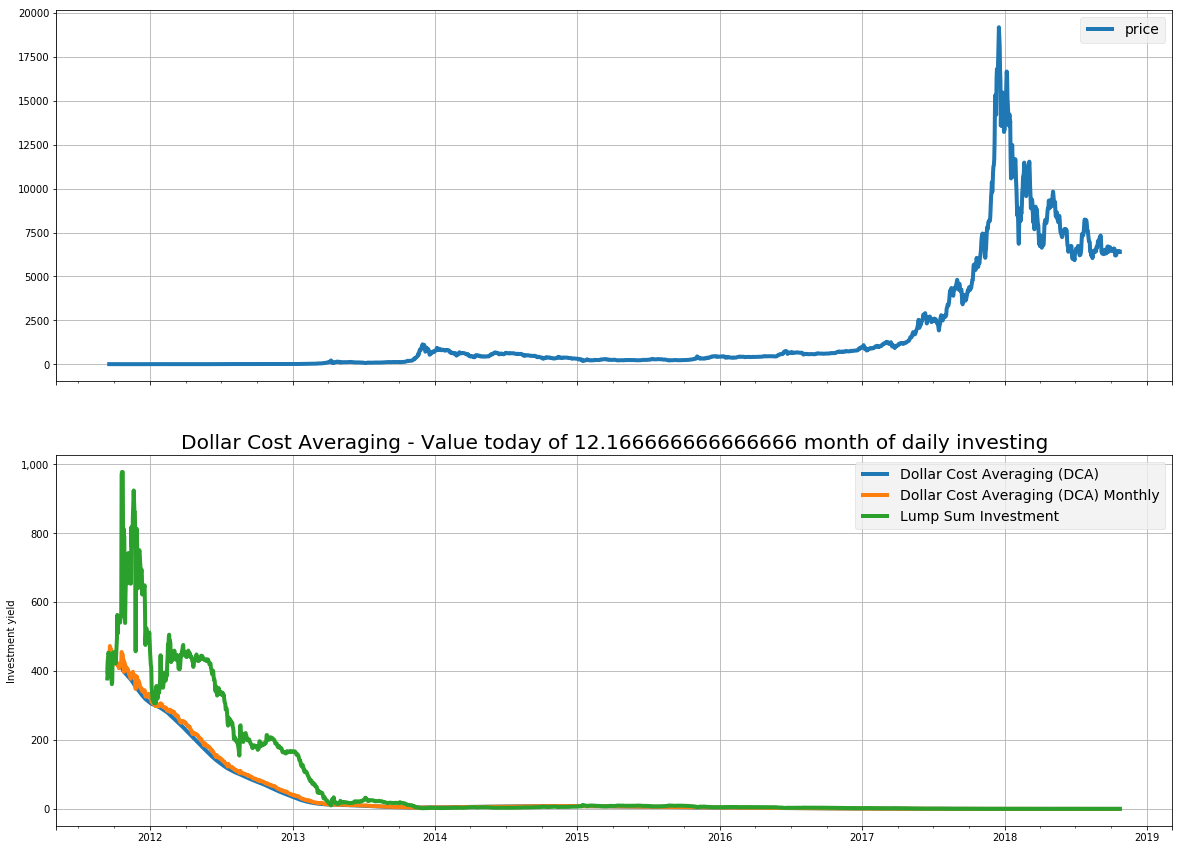

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import style

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(20,15))

style.use('fivethirtyeight')
btc.plot(ax=ax1)
dca.plot(ax=ax2)
dca_monthly.plot(ax=ax2)
lump.plot(ax=ax2)

#ax = plt.subplot()
ax2.legend()
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Y axis dollarsymbols
plt.title("Dollar Cost Averaging - Value today of "+ str(number_of_days/30) + " month of daily investing")
plt.xlabel('')
plt.ylabel('Investment yield');

As one can see,  As we're comparing the investment to the price of bitcoin today, the returns on capital between 2011 and 2013 were insanely high. DCA is about 5 to tenfold worse then lump-sum investment. 
Because of that we can't see anything what's happening after 2014. So let's use Logscale and plot the same again including a chart which visualizes the difference of both approaches:

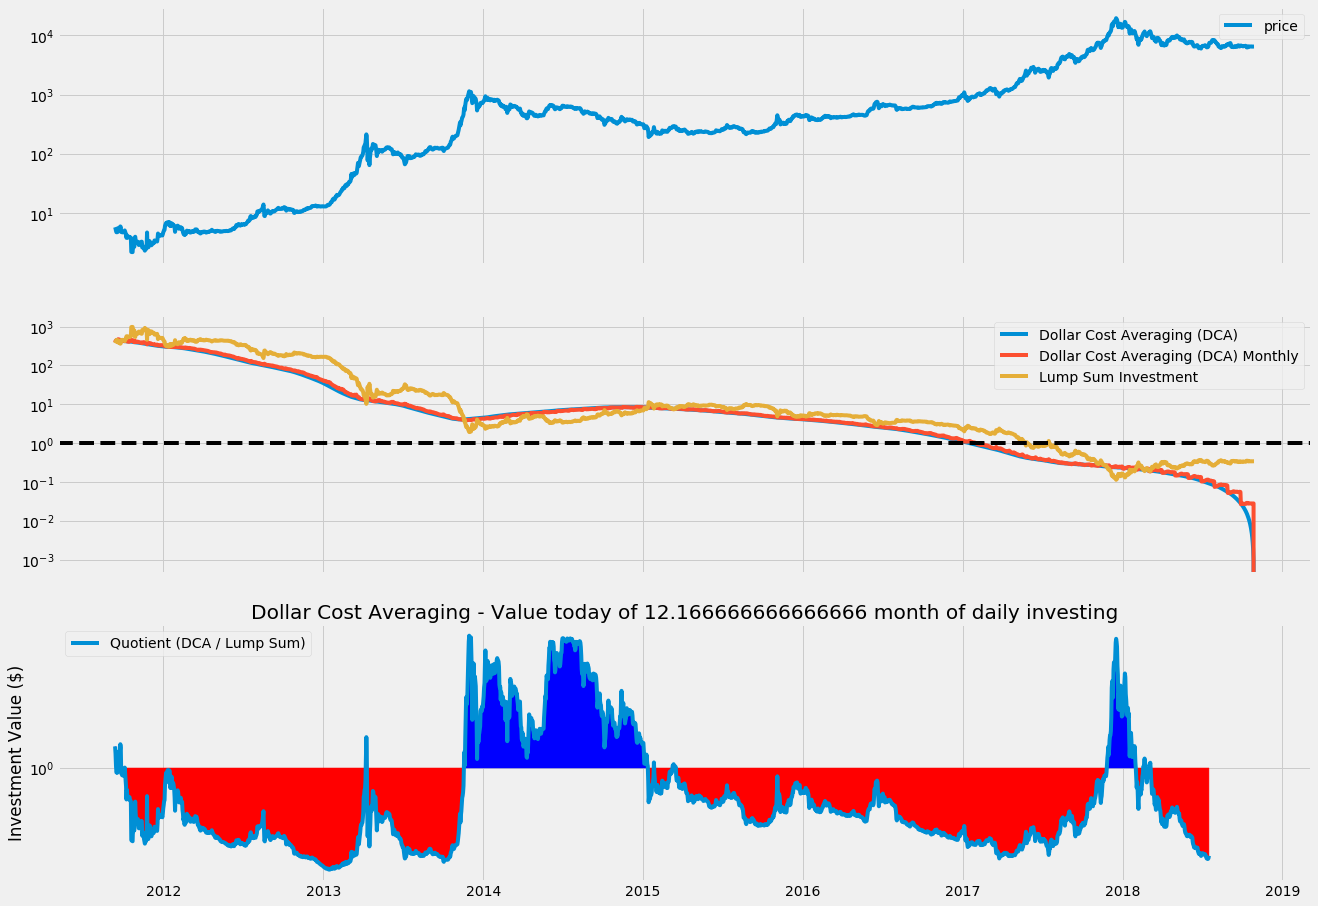

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import style

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,15))

style.use('fivethirtyeight')
btc.plot(ax=ax1)
dca.plot(ax=ax2)
dca_monthly.plot(ax=ax2)
lump.plot(ax=ax2)
quotient.plot(ax=ax3)

#ax = plt.subplot()
ax2.legend()
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Y axis dollarsymbols
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.title("Dollar Cost Averaging - Value today of "+ str(number_of_days/30) + " month of daily investing")
plt.xlabel('')
plt.ylabel('Investment Value ($)');
ax2.axhline(1, alpha=1, linestyle="--", color="black")

# Difference#
ax3.legend()
ax3.set_yscale('symlog')
ax3.fill_between(quotient.index, y1=quotient, y2=1, color='blue', where=quotient>1)
ax3.fill_between(quotient.index, y1=quotient, y2=1, color='red', where=quotient<1)

#ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x*1e-3))) # Y axis $1,000s
#ax3.set_ylabel('Difference ($)')
#ax3.set_title('Difference (Lump Sum - Dollar Cost Average)')
#ax3.legend(["Lump Sum > DCA", "DCA > Lump Sum"]);